In [0]:
import pandas as pd
import numpy as np
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0)


In [0]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)


In [8]:
np.set_printoptions(precision=4)

mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print('MV %s: %s\n' % (label, mean_vecs[label - 1]))



MV 1: [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]

MV 2: [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]

MV 3: [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]



In [9]:
d = 13  # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))  # scatter matrix for each class
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)  # make column vectors
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter                          # sum class scatter matrices

print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))


Within-class scatter matrix: 13x13


In [0]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13  # number of features
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # make column vector
    mean_overall = mean_overall.reshape(d, 1)  # make column vector
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)


In [0]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [12]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])



Eigenvalues in decreasing order:

10.8511098789561
3.843069541603848
1.4580067296223597e-15
1.1993749651754465e-15
7.158531802125913e-16
7.158531802125913e-16
4.440892098500626e-16
3.1629413823766413e-16
2.841858434487296e-16
2.841858434487296e-16
2.0084288743232904e-16
2.0084288743232904e-16
3.638356921698454e-17


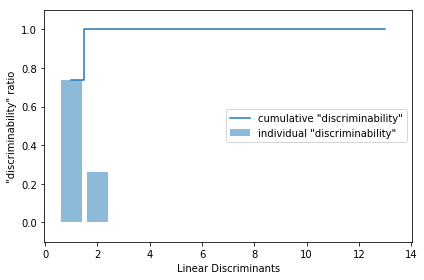

In [15]:
import matplotlib.pyplot as plt
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, alpha=0.5, align='center',
        label='individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid',
         label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('./figures/lda1.png', dpi=300)
plt.show()


In [16]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)


Matrix W:
 [[-0.0758 -0.3623]
 [ 0.0387 -0.2479]
 [-0.0232 -0.3675]
 [ 0.1955  0.2953]
 [-0.0072  0.0233]
 [ 0.2424  0.0108]
 [-0.764   0.2106]
 [-0.082   0.0715]
 [ 0.094   0.1604]
 [ 0.2146 -0.3514]
 [-0.0556  0.2004]
 [-0.3623  0.0437]
 [-0.3398 -0.5862]]


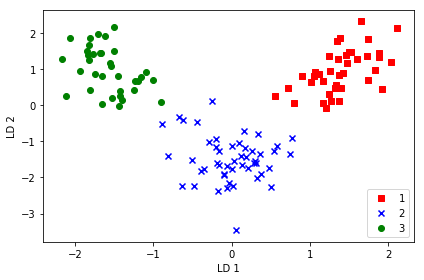

In [17]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0] * (-1),
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=l, marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig('./figures/lda2.png', dpi=300)
plt.show()


In [0]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier,test_idx = None, resolution=0.02):
    #setup marker generator and colormap
    markers = ('s','x','o','^','v')
    colors = ('red','blue','lightgreen','gray','cyan')
    cmap = ListedColormap(colors[: len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:,0].min() -1, X[:,0].max()+1
    x2_min, x2_max = X[:,1].min() -1, X[:,1].max()+1
    # X[:,k] 冒号左边表示行范围，读取所有行，冒号右边表示列范围，读取第K列
    xx1, xx2 = np.meshgrid(np.arange(x1_min,x1_max,resolution),
                           np.arange(x2_min,x2_max,resolution))
    #arange(start,end,step) 返回一个一维数组
    #meshgrid(x,y)产生一个以x为行，y为列的矩阵
    #xx1是一个(305*235)大小的矩阵 xx1.ravel()是将所有的行放在一个行里面的长度71675的一维数组
    #xx2同理
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    #np.array([xx1.ravel(), xx2.ravel()]) 生成了一个 (2*71675)的矩阵
    # xx1.ravel() = (1,71675)
    #xx1.shape = (305,205) 将Z重新调整为(305,205)的格式
    Z = Z.reshape(xx1.shape)

    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)

    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    print(np.unique(y))
    # idx = 0,1 cl = -1 1
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl, 0], y=X[y==cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker = markers[idx],label = cl)
    #highlight test samples   
    #增加的模块
    if test_idx:
        X_test, y_test = X[test_idx,:],y[test_idx]
        plt.scatter(X_test[:,0],X_test[:,1],c='',edgecolors='0',
                    alpha=1.0, linewidths=1,marker='o',
                    s=55, label='test set')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all poi

[1 2 3]


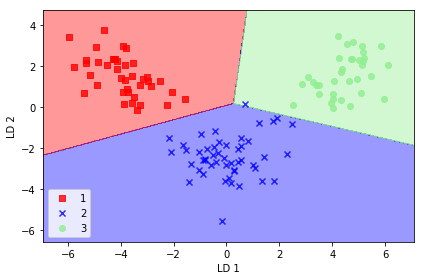

In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./images/lda3.png', dpi=300)
plt.show()


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


[1 2 3]


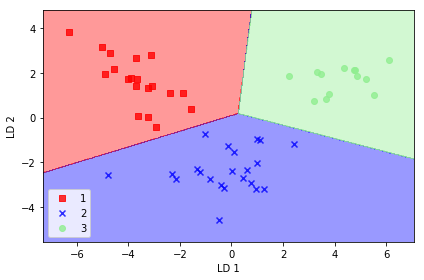

In [26]:
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./images/lda4.png', dpi=300)
plt.show()
